In [61]:
!pip install pandas scikit-learn rapidfuzz
!pip install pandas pyarrow fastparquet seaborn

In [62]:
import pandas as pd
from rapidfuzz import fuzz
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, roc_curve
)
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df = pd.read_parquet("data.parquet")

In [34]:
df. head ( )
df. info()
df. describe()
df. shape
df. columns
# Show first 5 rows
# Summary of columns and data types
# Statistical summary of numeric columns
# Number of rows and columns
# Column names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     3000 non-null   object 
 1   base_id                3000 non-null   object 
 2   sources                3000 non-null   object 
 3   names                  3000 non-null   object 
 4   categories             2957 non-null   object 
 5   confidence             3000 non-null   float64
 6   websites               2459 non-null   object 
 7   socials                2090 non-null   object 
 8   emails                 0 non-null      object 
 9   phones                 2765 non-null   object 
 10  brand                  884 non-null    object 
 11  addresses              3000 non-null   object 
 12  base_sources           3000 non-null   object 
 13  base_names             3000 non-null   object 
 14  base_categories        2960 non-null   object 
 15  base

Index(['id', 'base_id', 'sources', 'names', 'categories', 'confidence',
       'websites', 'socials', 'emails', 'phones', 'brand', 'addresses',
       'base_sources', 'base_names', 'base_categories', 'base_confidence',
       'base_websites', 'base_socials', 'base_emails', 'base_phones',
       'base_brand', 'base_addresses', 'addresses_parsed',
       'base_addresses_parsed', 'addr_norm', 'base_addr_norm'],
      dtype='object')

In [44]:
## Parsing and Normalizing DataFrame

In [41]:
import json, math
from ast import literal_eval

def is_nan(x):
    return isinstance(x, float) and math.isnan(x)

def safe_parse(x):
    # Return a real Python list/dict, or [] on failure (not None)
    if x is None or is_nan(x):
        return []
    if isinstance(x, (list, dict)):
        return x
    if isinstance(x, str):
        try:
            return json.loads(x)                  # valid JSON
        except Exception:
            try:
                return literal_eval(x)            # Python-ish strings with single quotes
            except Exception:
                return []                         # fallback
    return []

def normalize_json(obj):
    # Compare apples-to-apples: first element of list, or empty dict
    if isinstance(obj, list):
        obj = obj[0] if obj else {}
    if isinstance(obj, dict):
        return json.dumps(obj, sort_keys=True, ensure_ascii=False)
    return "{}"  # never return "None"

df["addresses_parsed"]       = df["addresses"].apply(safe_parse)
df["base_addresses_parsed"]  = df["base_addresses"].apply(safe_parse)

df["addr_norm"]      = df["addresses_parsed"].apply(normalize_json)
df["base_addr_norm"] = df["base_addresses_parsed"].apply(normalize_json)

print("non-null parsed (left/right):",
      df["addresses_parsed"].notna().sum(),
      df["base_addresses_parsed"].notna().sum())

print("distinct rows after filter:",
      (df["addr_norm"] != df["base_addr_norm"]).sum())


non-null parsed (left/right): 3000 3000
distinct rows after filter: 2466


In [ ]:
## Create labelled data (0 for addresses that don't match and 1 for ones that do)

In [42]:
df_pos = df[df["addr_norm"] != df["base_addr_norm"]].copy()
df_pos["label"] = 1
positives = df_pos[["addresses","base_addresses","label"]].copy()

# simple negatives: mismatch by shuffling base side
base_shuffled = df_pos["base_addresses"].sample(frac=1, random_state=42).reset_index(drop=True)
negatives = pd.DataFrame({
    "addresses": df_pos["addresses"].values,
    "base_addresses": base_shuffled.values,
    "label": 0
})
negatives = negatives[negatives["addresses"] != negatives["base_addresses"]]

df_final = pd.concat([positives, negatives], ignore_index=True).sample(frac=1, random_state=42)
print(df_final["label"].value_counts())

label
0    2466
1    2466
Name: count, dtype: int64


In [40]:
print(df_final["label"].value_counts())
df_final.head(10)

label
0    2466
1    2466
Name: count, dtype: int64


,addresses,base_addresses,label
4390,"[{""freeform"":""Avenida Duque de Caxias, 82"",""lo...","[{""freeform"":""4130 E 82nd St"",""locality"":""Indi...",0
1212,"[{""freeform"":""Centro Universitario de Ciencias...","[{""freeform"":""Centro Universitario de Ciencias...",1
4476,"[{""freeform"":""59-61 Commercial Road"",""locality...","[{""freeform"":""Piazza Bertati, 1"",""locality"":""M...",0
4324,"[{""freeform"":""210 W 59th St"",""locality"":""New Y...","[{""freeform"":""171 Reservoir Ave"",""locality"":""R...",0
151,"[{""freeform"":""1115 Highway 93 S"",""locality"":""S...","[{""freeform"":""1115 Highway 93 S"",""locality"":""S...",1
544,"[{""freeform"":""12300 Lake June Rd"",""locality"":""...","[{""freeform"":""12300 LAKE JUNE Rd"",""locality"":""...",1
2226,"[{""freeform"":""Viale delle Grazie, 10"",""localit...","[{""freeform"":""Via Delle Grazie 10"",""locality"":...",1
84,"[{""freeform"":""200 W I65 Service Rd S"",""localit...","[{""freeform"":""200 W i65 Service Rd S"",""localit...",1
670,"[{""freeform"":""C. Vista Alegre, 4"",""postcode"":""...","[{""freeform"":""Calle Padre-Damián, 24"",""localit...",1
949,"[{""freeform"":""827 N Easton Rd"",""locality"":""Doy...","[{""freeform"":""841 N Easton Rd"",""locality"":""Doy...",1


In [51]:
for i, row in df_final[["addresses", "base_addresses", "label"]].head(5).iterrows():
    print(f"🔹 Row {i}")
    print("addresses:      ", row['addresses'])
    print("base_addresses: ", row['base_addresses'])
    print("label: ", row['label'])
    print("-" * 80)

🔹 Row 4390
addresses:       [{"freeform":"Avenida Duque de Caxias, 82","locality":"Pelotas","postcode":"96030-000","region":"RS","country":"BR"}]
base_addresses:  [{"freeform":"4130 E 82nd St","locality":"Indianapolis","region":"IN","country":"US","postcode":"46250"}]
label:  0
--------------------------------------------------------------------------------
🔹 Row 1212
addresses:       [{"freeform":"Centro Universitario de Ciencias Biológicas y Agropecuarias","country":"MX"}]
base_addresses:  [{"freeform":"Centro Universitario de Ciencias Biológicas y Agropecuarias (CUCBA)","region":"Jal","country":"MX"}]
label:  1
--------------------------------------------------------------------------------
🔹 Row 4476
addresses:       [{"freeform":"59-61 Commercial Road","locality":"Bournemouth","postcode":"BH2 5","region":"ENG","country":"GB"}]
base_addresses:  [{"freeform":"Piazza Bertati, 1","locality":"Martellago","region":"VE","country":"IT","postcode":"30030"}]
label:  0
----------------------

In [52]:
## Building Correlation Map

In [54]:
# nevermind

In [55]:
df = df_final
def to_string(addr):
    if isinstance(addr, str):
        try:
            a = json.loads(addr)
            if isinstance(a, list) and a:
                a = a[0]
            if isinstance(a, dict):
                return " ".join(str(v) for v in a.values() if v)
        except Exception:
            return addr
    elif isinstance(addr, list) and addr:
        a = addr[0]
        if isinstance(a, dict):
            return " ".join(str(v) for v in a.values() if v)
    elif isinstance(addr, dict):
        return " ".join(str(v) for v in addr.values() if v)
    return str(addr)

df["addr_str"] = df["addresses"].apply(to_string)
df["base_addr_str"] = df["base_addresses"].apply(to_string)

In [56]:
def fuzzy_features(a, b):
    a, b = str(a).lower(), str(b).lower()
    return {
        "ratio": fuzz.ratio(a, b) / 100,
        "partial_ratio": fuzz.partial_ratio(a, b) / 100,
        "token_sort": fuzz.token_sort_ratio(a, b) / 100,
        "token_set": fuzz.token_set_ratio(a, b) / 100,
    }

feat_df = df.apply(lambda r: pd.Series(fuzzy_features(r["addr_str"], r["base_addr_str"])), axis=1)
df_feat = pd.concat([feat_df, df["label"]], axis=1)
df_feat.head()


,ratio,partial_ratio,token_sort,token_set,label
4390,0.333333,0.384615,0.355556,0.355556,0
1212,0.911765,0.983607,0.911765,1.000000,1
4476,0.279070,0.328767,0.302326,0.302326,0
4324,0.358974,0.400000,0.410256,0.461538,0
151,0.779221,0.909091,0.935065,0.935065,1


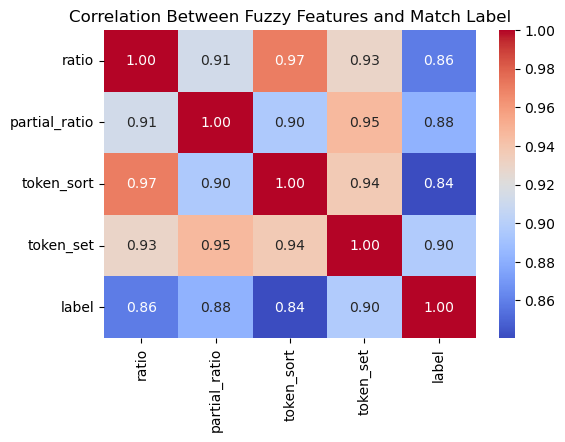

In [63]:
corr = df_feat.corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Fuzzy Features and Match Label")
plt.show()

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

# Choose your feature pair
X = df_feat[["token_set", "partial_ratio"]]   # or try ["token_set", "ratio"]
y = df_feat["label"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Train simple logistic regression
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict & evaluate
y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

print("ROC AUC :", roc_auc_score(y_test, y_score))
print(classification_report(y_test, y_pred, digits=3))


ROC AUC : 0.9972612526792093
              precision    recall  f1-score   support

           0      0.978     0.998     0.988       494
           1      0.998     0.978     0.988       493

    accuracy                          0.988       987
   macro avg      0.988     0.988     0.988       987
weighted avg      0.988     0.988     0.988       987



In [65]:
for feature, coef in zip(X.columns, model.coef_[0]):
    print(f"{feature:15s} weight: {coef:.3f}")

token_set       weight: 11.041
partial_ratio   weight: 9.771


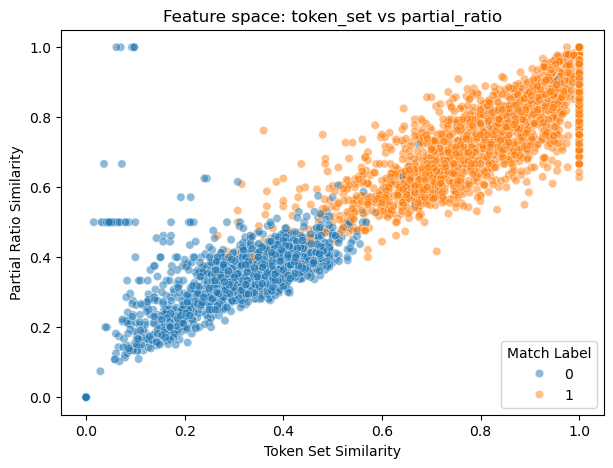

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
sns.scatterplot(x="token_set", y="partial_ratio", hue="label", data=df_feat, alpha=0.5)
plt.title("Feature space: token_set vs partial_ratio")
plt.xlabel("Token Set Similarity")
plt.ylabel("Partial Ratio Similarity")
plt.legend(title="Match Label")
plt.show()
